<a id='top'></a>
# How to slice and dice the data
Below are a series of examples on how to slice and dice the data that is stored in the *.sqlite* file generated by the [MorningStar.com](https://www.morningstar.com) scraper. 


**Content:**
- [Required modules and matplotlib backend](#modules)
- [Creating a master (bridge table) DataFrame instance using the DataFrames class](#master)
- [Creating DataFrame instances with the dataframes methods](#methods)
- [Statistics on data downloaded by scraper](#stats)
- [Additional Sample Code](#sample)

<a id="modules"></a>
## Required modules and matplotlib backend

In [92]:
%matplotlib notebook

In [93]:
import matplotlib.pyplot as plt
import matplotlib

In [94]:
from importlib import reload
import pandas as pd
import numpy as np

# Import dataframes module from project folder.
# This module contains a class that reads the database tables and assigns the data to pandas.DataFrame objects
import dataframes
reload(dataframes) #reload if changes have been made to module file

<module 'dataframes' from '/home/cbrandao/lib/python/msTables/dataframes.py'>

[return to the top](#top)
<a id="master"></a>
## Creating a master DataFrame instance using the dataframes class
The DataFrames class is part of the [dataframes module](dataframes.py)

In [95]:
db_file_name = 'mstables2' # Change the file name here as needed
df = dataframes.DataFrames('db/{}.sqlite'.format(db_file_name))

Creating intial DataFrames from file db/mstables2.sqlite...
Creating DataFrame 'colheaders' ...
Creating DataFrame 'timerefs' ...
Creating DataFrame 'urls' ...
Creating DataFrame 'securitytypes' ...
Creating DataFrame 'tickers' ...
Creating DataFrame 'sectors' ...
Creating DataFrame 'industries' ...
Creating DataFrame 'stockstyles' ...
Creating DataFrame 'exchanges' ...
Creating DataFrame 'countries' ...
Creating DataFrame 'companies' ...
Creating DataFrame 'currencies' ...
Creating DataFrame 'stocktypes' ...
Creating DataFrame 'master' ...
Initial DataFrames created.


### Creating Master DataFrame instance from reference tables
By merging `df.master` (*Master* bridge table) with other reference tables (e.g. `df.tickers`, `df.exchanges`, etc.)
##### DataFrame Instance

In [266]:
# Merge Tables
df_master0 = (df.master
# Ticker Symbols
 .merge(df.tickers, left_on='ticker_id', right_on='id').drop(['id'], axis=1)
# Company / Security Name
 .merge(df.companies, left_on='company_id', right_on='id').drop(['id', 'company_id'], axis=1)
# Exchanges
 .merge(df.exchanges, left_on='exchange_id', right_on='id').drop(['id'], axis=1)
# Industries
 .merge(df.industries, left_on='industry_id', right_on='id').drop(['id', 'industry_id'], axis=1)
# Sectors
 .merge(df.sectors, left_on='sector_id', right_on='id').drop(['id', 'sector_id'], axis=1)
# Countries
 .merge(df.countries, left_on='country_id', right_on='id').drop(['id', 'country_id'], axis=1)
# Security Types
 .merge(df.securitytypes, left_on='security_type_id', right_on='id').drop(['id', 'security_type_id'], axis=1)
# Stock Types
 .merge(df.stocktypes, left_on='stock_type_id', right_on='id').drop(['id', 'stock_type_id'], axis=1)
# Stock Style Types
 .merge(df.styles, left_on='style_id', right_on='id').drop(['id', 'style_id'], axis=1)
# Quote Header Info
 .merge(df.quoteheader(), on=['ticker_id', 'exchange_id'])#.drop(['id', 'style_id'], axis=1)
              .rename(columns={'fpe':'Forward_PE'})
# Currency
 .merge(df.currencies, left_on='currency_id', right_on='id').drop(['id', 'currency_id'], axis=1)
# Fiscal Year End
 .merge(df.timerefs, left_on='fyend_id', right_on='id').drop(['fyend_id'], axis=1)
             .rename(columns={'dates':'fy_end'})
# Updated Date
 .merge(df.timerefs, left_on='update_date_id', right_on='id').drop(['update_date_id'], axis=1)
             .rename(columns={'dates':'updated_date'})
)

# Change date columns to TimeFrames
df_master0['fy_end'] = pd.to_datetime(df_master0['fy_end'])
df_master0['updated_date'] = pd.to_datetime(df_master0['updated_date'])

# Final Table with openprice > 0
df_master = df_master0.where(df_master0['openprice'] > 0.0).dropna(axis=0, how='all')
df_master.head()

,ticker_id,exchange_id,ticker,company,exchange,exchange_sym,industry,sector,country,a2_iso,...,aprvol,avevol,Forward_PE,pb,ps,pc,currency,currency_code,fy_end,updated_date
0,1.0,374.0,OGCP,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,ARCX,REIT - Diversified,Real Estate,United States,US,...,NaN,NaN,NaN,2.4,6.4,16.9,United States Dollar,USD,2019-12-31,2019-03-26
1,2.0,374.0,FISK,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,ARCX,REIT - Diversified,Real Estate,United States,US,...,NaN,NaN,NaN,2.4,6.4,16.8,United States Dollar,USD,2019-12-31,2019-03-26
2,3.0,374.0,ESBA,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,ARCX,REIT - Diversified,Real Estate,United States,US,...,NaN,NaN,NaN,2.4,6.4,16.8,United States Dollar,USD,2019-12-31,2019-03-26
3,19437.0,302.0,PSB,PS Business Parks Inc,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Diversified,Real Estate,United States,US,...,NaN,NaN,NaN,5.2,10.1,15.2,United States Dollar,USD,2019-12-31,2019-03-26
4,20371.0,302.0,STOR,STORE Capital Corp,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Diversified,Real Estate,United States,US,...,14000000.0,17000000.0,NaN,1.9,12.6,17.3,United States Dollar,USD,2019-12-31,2019-03-26


##### DataFrame Length

In [97]:
print('Master DataFrame contains {:,.0f} records.'.format(len(df_master)))

Master DataFrame contains 102,630 records.


##### DataFrame Columns

In [98]:
df_master.columns

Index(['ticker_id', 'exchange_id', 'ticker', 'company', 'exchange',
       'exchange_sym', 'industry', 'sector', 'country', 'a2_iso', 'a3_un',
       'security_type_code', 'security_type', 'stock_type', 'style',
       'openprice', 'lastprice', 'day_hi', 'day_lo', '_52wk_hi', '_52wk_lo',
       'yield', 'aprvol', 'avevol', 'Forward_PE', 'pb', 'ps', 'pc', 'currency',
       'currency_code', 'fy_end', 'updated_date'],
      dtype='object')

<br></br>
[return to the top](#top)
<a id='methods'></a>
## Creating DataFrame instances with dataframes methods
Class DataFrames from [dataframe.py](dataframe.py) contains the following methods that return a pd.DataFrame object for the specified database table:

- `quoteheader` - [MorningStar (MS) Quote Header](#quote)
- `valuation` - [MS Valuation table with Price Ratios (P/E, P/S, P/B, P/C) for the past 10 yrs](#val)
- `keyratios` - [MS Ratio - Key Financial Values](#keyratios)
- `finhealth` - [MS Ratio - Financial Health](#finhealth)
- `profitability` - [MS Ratio - Profitability](#prof)
- `growth` - [MS Ratio - Growth](#growth)
- `cfhealth` - [MS Ratio - Cash Flow Health](#cfh)
- `efficiency` - [MS Ratio - Efficiency](#eff)
- `annualIS` - [MS Annual Income Statement](#isa)
- `quarterlyIS` - [MS Quarterly Income Statement](#isq)
- `annualBS` - [MS Annual Balance Sheet](#bsa)
- `quarterlyBS` - [MS Quarterly Balance Sheet](#bsq)
- `annualCF` - [MS Annual Cash Flow Statement](#cfa)
- `quarterlyCF` - [MS Quarterly Cash Flow Statement](#cfq)
- `pricehistory` - MSpricehistory

<br></br>
[return to the top](#top)

<a id='quote'></a>
### Quote Header 
##### DataFrame Instance

In [14]:
df_quote0 = df.quoteheader()
df_quote0.head()

,ticker_id,exchange_id,openprice,lastprice,day_hi,day_lo,_52wk_hi,_52wk_lo,yield,aprvol,avevol,fpe,pb,ps,pc,currency_id
0,1,374,15.84,15.82,15.82,15.84,12.16,17.72,2.65,NaN,NaN,NaN,2.4,6.4,16.9,104
1,2,374,15.73,15.73,15.73,15.73,13.68,17.68,2.67,NaN,NaN,NaN,2.4,6.4,16.8,104
2,3,374,15.91,15.78,15.71,15.91,11.99,17.79,2.66,NaN,NaN,NaN,2.4,6.4,16.8,104
3,4,482,95.43,95.88,95.11,96.06,87.87,115.36,1.26,11000000.0,NaN,19.7,3.3,3.9,20.0,104
4,5,1,0.00,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104


##### DataFrame Length

In [15]:
print('DataFrame contains {:,.0f} records.'.format(len(df_quote0)))

DataFrame contains 116,137 records.


<a id='val'></a>
### Price Ratios (P/E, P/S, P/B, P/C)
[return to list of methods](#methods)
##### DataFrame Instance

In [16]:
df_val0 = df.valuation().reset_index()
df_val0.head()

,exchange_id,ticker_id,PE_2009,PE_2010,PE_2011,PE_2012,PE_2013,PE_2014,PE_2015,PE_2016,...,PC_2010,PC_2011,PC_2012,PC_2013,PC_2014,PC_2015,PC_2016,PC_2017,PC_2018,PC_TTM
0,374,1,NaN,NaN,NaN,NaN,NaN,18.6,69.0,57.8,...,NaN,NaN,NaN,48.3,-153.8,24.3,25.8,26.3,21.5,16.9
1,374,2,NaN,NaN,NaN,NaN,NaN,18.2,69.0,58.8,...,NaN,NaN,NaN,50.5,-151.5,24.3,26.2,26.4,20.3,16.8
2,374,3,NaN,NaN,NaN,NaN,NaN,18.3,69.4,58.8,...,NaN,NaN,NaN,48.3,-153.8,24.4,26.2,26.7,20.6,16.8
3,482,4,NaN,22.2,17.4,16.6,27.0,29.7,26.6,31.7,...,16.2,11.1,12.9,19.6,23.1,19.9,26.8,52.9,21.8,20.0
4,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### DataFrame Length

In [17]:
print('DataFrame contains {:,.0f} records.'.format(len(df_val0)))

DataFrame contains 78,959 records.


##### DataFrame Columnns

In [18]:
df_val0.columns

Index(['exchange_id', 'ticker_id', 'PE_2009', 'PE_2010', 'PE_2011', 'PE_2012',
       'PE_2013', 'PE_2014', 'PE_2015', 'PE_2016', 'PE_2017', 'PE_2018',
       'PE_TTM', 'PS_2009', 'PS_2010', 'PS_2011', 'PS_2012', 'PS_2013',
       'PS_2014', 'PS_2015', 'PS_2016', 'PS_2017', 'PS_2018', 'PS_TTM',
       'PB_2009', 'PB_2010', 'PB_2011', 'PB_2012', 'PB_2013', 'PB_2014',
       'PB_2015', 'PB_2016', 'PB_2017', 'PB_2018', 'PB_TTM', 'PC_2009',
       'PC_2010', 'PC_2011', 'PC_2012', 'PC_2013', 'PC_2014', 'PC_2015',
       'PC_2016', 'PC_2017', 'PC_2018', 'PC_TTM'],
      dtype='object')

<a id='keyratios'></a>
### Other Key Values
[return to list of methods](#methods)
##### DataFrame Instance

In [19]:
df_ratio0 = df.keyratios()

In [20]:
df_ratio0.head()

,ticker_id,exchange_id,i0,i0_Y0,i0_Y1,i0_Y2,i0_Y3,i0_Y4,i0_Y5,i0_Y6,...,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10
0,1,374,202,NaN,NaN,295.0,260.0,312.0,635.0,658.0,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
1,2,374,202,NaN,NaN,295.0,260.0,312.0,635.0,658.0,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
2,3,374,202,NaN,NaN,295.0,260.0,312.0,635.0,658.0,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
3,4,482,202,426.0,437.0,508.0,512.0,572.0,617.0,635.0,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
4,23,1,202,28.0,33.0,33.0,28.0,28.0,3.0,20.0,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM


##### DataFrame Length

In [21]:
print('DataFrame contains {:,.0f} records.'.format(len(df_ratio0)))

DataFrame contains 76,238 records.


##### DataFrame Columnns

In [22]:
(df_ratio0.loc[0, [col for col in df_ratio0.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

i0                      Revenue
i1                 Gross_Margin
i2             Operating_Income
i3             Operating_Margin
i4                   Net_Income
i5           Earnings_Per_Share
i6                    Dividends
i91                Payout_Ratio
i7                       Shares
i8         Book_Value_Per_Share
i9          Operating_Cash_Flow
i10                Cap_Spending
i11              Free_Cash_Flow
i90    Free_Cash_Flow_Per_Share
i80             Working_Capital
Name: 0, dtype: object

<a id='finhealth'></a>
### Financial Health
[return to list of methods](#methods)
##### DataFrame Instance

In [23]:
df_fin0 = df.finhealth()

In [24]:
df_fin0.head()

,ticker_id,exchange_id,fh_balsheet,fh_Y0,fh_Y1,fh_Y2,fh_Y3,fh_Y4,fh_Y5,fh_Y6,...,i68_lfh_Y1,i68_lfh_Y2,i68_lfh_Y3,i68_lfh_Y4,i68_lfh_Y5,i68_lfh_Y6,i68_lfh_Y7,i68_lfh_Y8,i68_lfh_Y9,i68_lfh_Y10
0,1,374,324,40,41,42,43,44,11,12,...,NaN,NaN,NaN,1.2,1.17,1.19,0.81,0.85,0.96,0.96
1,2,374,324,40,41,42,43,44,11,12,...,NaN,NaN,NaN,1.2,1.17,1.19,0.81,0.85,0.96,0.96
2,3,374,324,40,41,42,43,44,11,12,...,NaN,NaN,NaN,1.2,1.17,1.19,0.81,0.85,0.96,0.96
3,4,482,324,40,41,42,43,44,11,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.40,0.28,0.28
4,5,1,324,697,698,699,700,701,668,669,...,NaN,NaN,NaN,NaN,4.34,3.53,2.07,NaN,0.28,1.34


##### DataFrame Length

In [25]:
print('DataFrame contains {:,.0f} records.'.format(len(df_fin0)))

DataFrame contains 76,234 records.


##### DataFrame Columns

In [26]:
# Financial Health DataFrame Columns
(df_fin0.loc[0, [col for col in df_fin0.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

fh_balsheet         Balance Sheet Items (in %)
i45              Cash & Short-Term Investments
i46                        Accounts Receivable
i47                                  Inventory
i48                       Other Current Assets
i49                       Total Current Assets
i50                                   Net PP&E
i51                                Intangibles
i52                     Other Long-Term Assets
i53                               Total Assets
i54                           Accounts Payable
i55                            Short-Term Debt
i56                              Taxes Payable
i57                        Accrued Liabilities
i58               Other Short-Term Liabilities
i59                  Total Current Liabilities
i60                             Long-Term Debt
i61                Other Long-Term Liabilities
i62                          Total Liabilities
i63                  Total Stockholders Equity
i64                 Total Liabilities & Equity
lfh_liquidity

<a id='prof'></a>
### Profitability
[return to list of methods](#methods)
##### DataFrame Instance

In [27]:
df_prof0 = df.profitability()

In [28]:
df_prof0.head()

,ticker_id,exchange_id,pr_margins,pr_Y0,pr_Y1,pr_Y2,pr_Y3,pr_Y4,pr_Y5,pr_Y6,...,i95_pr_pro_Y1,i95_pr_pro_Y2,i95_pr_pro_Y3,i95_pr_pro_Y4,i95_pr_pro_Y5,i95_pr_pro_Y6,i95_pr_pro_Y7,i95_pr_pro_Y8,i95_pr_pro_Y9,i95_pr_pro_Y10
0,1,374,279,40,41,42,43,44,11,12,...,NaN,2.05,1.89,4.52,2.13,2.24,2.59,2.82,2.53,2.53
1,2,374,279,40,41,42,43,44,11,12,...,NaN,2.05,1.89,4.52,2.13,2.24,2.59,2.82,2.53,2.53
2,3,374,279,40,41,42,43,44,11,12,...,NaN,2.05,1.89,4.52,2.13,2.24,2.59,2.82,2.53,2.53
3,4,482,279,40,41,42,43,44,11,12,...,184.73,274.13,NaN,NaN,NaN,NaN,NaN,8.85,15.10,15.10
4,5,1,279,697,698,699,700,701,668,669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### DataFrame Length

In [29]:
print('DataFrame contains {:,.0f} records.'.format(len(df_prof0)))

DataFrame contains 76,234 records.


##### DataFrame Columns

In [30]:
# Financial Health DataFrame Columns
(df_prof0.loc[0, [col for col in df_prof0.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

pr_margins              Margins % of Sales
i12                                Revenue
i13                                   COGS
i14                           Gross Margin
i15                                   SG&A
i16                                    R&D
i17                                  Other
i18                       Operating Margin
i19                    Net Int Inc & Other
i20                             EBT Margin
pr_profit                    Profitability
i21                             Tax Rate %
i22                           Net Margin %
i23               Asset Turnover (Average)
i24                     Return on Assets %
i25           Financial Leverage (Average)
i26                     Return on Equity %
i27           Return on Invested Capital %
i95                      Interest Coverage
Name: 0, dtype: object

<a id='growth'></a>
### Growth
[return to list of methods](#methods)
##### DataFrame Instance

In [31]:
df_grow0 = df.growth()

In [32]:
df_grow0.head()

,ticker_id,exchange_id,gr_Y0,gr_Y1,gr_Y2,gr_Y3,gr_Y4,gr_Y5,gr_Y6,gr_Y7,...,i39_gr_Y1,i39_gr_Y2,i39_gr_Y3,i39_gr_Y4,i39_gr_Y5,i39_gr_Y6,i39_gr_Y7,i39_gr_Y8,i39_gr_Y9,i39_gr_Y10
0,1,374,40,41,42,43,44,11,12,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1,2,374,40,41,42,43,44,11,12,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
2,3,374,40,41,42,43,44,11,12,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
3,4,482,40,41,42,43,44,11,12,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.73,None
4,5,1,697,698,699,700,701,668,669,670,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


##### DataFrame Length

In [33]:
print('DataFrame contains {:,.0f} records.'.format(len(df_grow0)))

DataFrame contains 76,234 records.


##### DataFrame Columns

In [34]:
# Financial Health DataFrame Columns
(df_grow0.loc[0, [col for col in df_grow0.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

gr_revenue               Revenue %
i28                 Year over Year
i29                 3-Year Average
i30                 5-Year Average
i31                10-Year Average
gr_operating    Operating Income %
i32                 Year over Year
i33                 3-Year Average
i34                 5-Year Average
i35                10-Year Average
gr_ni                 Net Income %
i81                 Year over Year
i82                 3-Year Average
i83                 5-Year Average
i84                10-Year Average
gr_eps                       EPS %
i36                 Year over Year
i37                 3-Year Average
i38                 5-Year Average
i39                10-Year Average
Name: 0, dtype: object

<a id='cfh'></a>
### Cash Flow Health
[return to list of methods](#methods)
##### DataFrame Instance

In [35]:
df_cfh0 = df.cfhealth()

In [36]:
df_cfh0.head()

,ticker_id,exchange_id,cf_cashflow,cf_Y0,cf_Y1,cf_Y2,cf_Y3,cf_Y4,cf_Y5,cf_Y6,...,i44_cf_Y1,i44_cf_Y2,i44_cf_Y3,i44_cf_Y4,i44_cf_Y5,i44_cf_Y6,i44_cf_Y7,i44_cf_Y8,i44_cf_Y9,i44_cf_Y10
0,1,374,318,40,41,42,43,44,11,12,...,NaN,-0.22,0.14,-0.91,-2.41,0.77,0.34,-0.27,2.40,2.40
1,2,374,318,40,41,42,43,44,11,12,...,NaN,-0.22,0.14,-0.91,-2.41,0.77,0.34,-0.27,2.40,2.40
2,3,374,318,40,41,42,43,44,11,12,...,NaN,-0.22,0.14,-0.91,-2.41,0.77,0.34,-0.27,2.40,2.40
3,4,482,318,40,41,42,43,44,11,12,...,1.12,1.25,1.08,1.11,1.12,1.00,0.99,0.84,1.17,1.17
4,5,1,318,697,698,699,700,701,668,669,...,NaN,NaN,NaN,1.00,0.80,1.13,0.50,1.16,0.83,0.50


##### DataFrame Length

In [37]:
print('DataFrame contains {:,.0f} records.'.format(len(df_cfh0)))

DataFrame contains 76,234 records.


##### DataFrame Columns

In [38]:
# Financial Health DataFrame Columns
(df_cfh0.loc[0, [col for col in df_cfh0.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

cf_cashflow                    Cash Flow Ratios
i40            Operating Cash Flow Growth % YOY
i41                 Free Cash Flow Growth % YOY
i42                      Cap Ex as a % of Sales
i43                      Free Cash Flow/Sales %
i44                   Free Cash Flow/Net Income
Name: 0, dtype: object

<a id='eff'></a>
### Efficiency
[return to list of methods](#methods)
##### DataFrame Instance

In [39]:
df_eff0 = df.efficiency()

In [40]:
df_eff0.head()

,ticker_id,exchange_id,ef_efficiency,ef_Y0,ef_Y1,ef_Y2,ef_Y3,ef_Y4,ef_Y5,ef_Y6,...,i76_ef_Y1,i76_ef_Y2,i76_ef_Y3,i76_ef_Y4,i76_ef_Y5,i76_ef_Y6,i76_ef_Y7,i76_ef_Y8,i76_ef_Y9,i76_ef_Y10
0,1,374,350,40,41,42,43,44,11,12,...,NaN,NaN,0.25,0.18,0.22,0.20,0.19,0.18,0.18,0.18
1,2,374,350,40,41,42,43,44,11,12,...,NaN,NaN,0.25,0.18,0.22,0.20,0.19,0.18,0.18,0.18
2,3,374,350,40,41,42,43,44,11,12,...,NaN,NaN,0.25,0.18,0.22,0.20,0.19,0.18,0.18,0.18
3,4,482,350,40,41,42,43,44,11,12,...,1.06,1.75,1.54,1.46,1.50,1.65,1.53,0.78,0.52,0.52
4,5,1,350,697,698,699,700,701,668,669,...,NaN,NaN,NaN,0.03,0.32,0.22,0.30,NaN,0.03,0.06


##### DataFrame Length

In [41]:
print('DataFrame contains {:,.0f} records.'.format(len(df_eff0)))

DataFrame contains 76,234 records.


##### DataFrame Columns

In [42]:
# Financial Health DataFrame Columns
(df_eff0.loc[0, [col for col in df_eff0.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

ef_efficiency                Efficiency
i69              Days Sales Outstanding
i70                      Days Inventory
i71                     Payables Period
i72               Cash Conversion Cycle
i73                Receivables Turnover
i74                  Inventory Turnover
i75               Fixed Assets Turnover
i76                      Asset Turnover
Name: 0, dtype: object

<a id='isa'></a>
### Annual Income Statement
[return to list of methods](#methods)
##### DataFrame Instance

In [43]:
df_isa0 = df.annualIS()

In [44]:
df_isa0.head()

,ticker_id,exchange_id,Year_Y_1,Year_Y_2,Year_Y_3,Year_Y_4,Year_Y_5,Year_Y_6,data_g1_Y_1,data_g1_Y_2,...,label_s4,label_s5,label_ttg1,label_ttg2,label_ttg3,label_tts1,label_tts2,label_tts3,label_tts4,label_tts5
0,1,374,2014-12,2015-12,2016-12,2017-12,2018-12,TTM,NaN,NaN,...,NaN,NaN,NaN,Total expenses,NaN,NaN,NaN,NaN,NaN,NaN
1,2,374,2014-12,2015-12,2016-12,2017-12,2018-12,TTM,NaN,NaN,...,NaN,NaN,NaN,Total expenses,NaN,NaN,NaN,NaN,NaN,NaN
2,3,374,2014-12,2015-12,2016-12,2017-12,2018-12,TTM,NaN,NaN,...,NaN,NaN,NaN,Total expenses,NaN,NaN,NaN,NaN,NaN,NaN
3,4,482,2014-12,2015-12,2016-12,2017-12,2018-12,TTM,NaN,NaN,...,Nonoperating income,NaN,NaN,NaN,NaN,NaN,Total operating expens...,NaN,Total nonoperating inc...,NaN
4,5,1,2003-12,2004-12,2005-12,2006-06,2007-06,TTM,NaN,NaN,...,NaN,NaN,NaN,NaN,Total operating expens...,NaN,NaN,NaN,NaN,NaN


##### DataFrame Length

In [45]:
print('DataFrame contains {:,.0f} records.'.format(len(df_isa0)))

DataFrame contains 76,211 records.


##### DataFrame Columns

In [76]:
# Financial Health DataFrame Columns
labels = [col for col in df_isa0 if 'label' in col]
df_isa_labels = pd.DataFrame([(label, uniq) for label in labels for uniq in df_isa0[label].unique()])
df_isa_labels.columns = ['label', 'text']
df_isa_labels.groupby('label')

<a id='isq'></a>
### Quarterly Income Statement
[return to list of methods](#methods)
##### DataFrame Instance

In [83]:
df_isq0 = df.quarterlyIS()

In [82]:
df_isq0.head()

,ticker_id,exchange_id,Year_Y_1,Year_Y_2,Year_Y_3,Year_Y_4,Year_Y_5,Year_Y_6,data_g1_Y_1,data_g1_Y_2,...,label_s4,label_s5,label_ttg1,label_ttg2,label_ttg3,label_tts1,label_tts2,label_tts3,label_tts4,label_tts5
0,1,374,2017-12,2018-03,2018-06,2018-09,2018-12,TTM,NaN,NaN,...,NaN,NaN,NaN,Total expenses,NaN,NaN,NaN,NaN,NaN,NaN
1,2,374,2017-12,2018-03,2018-06,2018-09,2018-12,TTM,NaN,NaN,...,NaN,NaN,NaN,Total expenses,NaN,NaN,NaN,NaN,NaN,NaN
2,3,374,2017-12,2018-03,2018-06,2018-09,2018-12,TTM,NaN,NaN,...,NaN,NaN,NaN,Total expenses,NaN,NaN,NaN,NaN,NaN,NaN
3,4,482,2017-12,2018-03,2018-06,2018-09,2018-12,TTM,NaN,NaN,...,Nonoperating income,NaN,NaN,NaN,NaN,NaN,Total operating expens...,NaN,Total nonoperating inc...,NaN
4,5,1,2007-03,2007-06,2007-09,2007-12,2008-03,TTM,NaN,NaN,...,NaN,NaN,NaN,NaN,Total operating expens...,NaN,NaN,NaN,NaN,NaN


##### DataFrame Length

In [48]:
print('DataFrame contains {:,.0f} records.'.format(len(df_isq0)))

DataFrame contains 56,589 records.


##### DataFrame Columns

In [49]:
# Financial Health DataFrame Columns
(df_isq0.loc[0, [col for col in df_isq0.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

label_g1                            NaN
label_g10     Weighted average share...
label_g2                       Expenses
label_g3                            NaN
label_g9             Earnings per share
label_i1                        Revenue
label_i10                           NaN
label_i11                           NaN
label_i12                           NaN
label_i13     Depreciation and amort...
label_i14     Sales, General and adm...
label_i15            Operating expenses
label_i16                           NaN
label_i17                           NaN
label_i18                           NaN
label_i19                           NaN
label_i2                            NaN
label_i20              Operating income
label_i21                           NaN
label_i22               Interest income
label_i23             Interest expenses
label_i24              Asset impairment
label_i25     Gain on sale of equity...
label_i26                           NaN
label_i27                           NaN


<a id='bsa'></a>
### Annual Balance Sheet
[return to list of methods](#methods)
##### DataFrame Instance

In [50]:
df_bsa0 = df.annualBS()

In [51]:
df_bsa0.head()

,ticker_id,exchange_id,Year_Y_1,Year_Y_2,Year_Y_3,Year_Y_4,Year_Y_5,data_g1_Y_1,data_g1_Y_2,data_g1_Y_3,...,label_ttg2,label_ttg5,label_ttg8,label_ttgg1,label_ttgg2,label_ttgg3,label_ttgg5,label_ttgg6,label_tts1,label_tts2
0,1,374,2014-12,2015-12,2016-12,2017-12,2018-12,NaN,NaN,NaN,...,NaN,Total liabilities,Total stockholders eq...,NaN,NaN,NaN,NaN,NaN,Total assets,Total liabilities and ...
1,2,374,2014-12,2015-12,2016-12,2017-12,2018-12,NaN,NaN,NaN,...,NaN,Total liabilities,Total stockholders eq...,NaN,NaN,NaN,NaN,NaN,Total assets,Total liabilities and ...
2,3,374,2014-12,2015-12,2016-12,2017-12,2018-12,NaN,NaN,NaN,...,NaN,Total liabilities,Total stockholders eq...,NaN,NaN,NaN,NaN,NaN,Total assets,Total liabilities and ...
3,4,482,2014-12,2015-12,2016-12,2017-12,2018-12,NaN,NaN,NaN,...,NaN,Total liabilities,Total stockholders eq...,NaN,NaN,NaN,NaN,NaN,Total assets,Total liabilities and ...
4,5,1,2003-12,2004-12,2005-12,2006-06,2007-06,0.0,19946.0,167141.0,...,Total non-current asse...,Total liabilities,Total stockholders eq...,Total cash,"Net property, plant an...",NaN,Total current liabilit...,Total non-current liab...,Total assets,Total liabilities and ...


##### DataFrame Length

In [52]:
print('DataFrame contains {:,.0f} records.'.format(len(df_bsa0)))

DataFrame contains 76,311 records.


##### DataFrame Columns

In [53]:
# Financial Health DataFrame Columns
(df_bsa0.loc[0, [col for col in df_bsa0.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

label_g1                             NaN
label_g2                             NaN
label_g5                     Liabilities
label_g8             Stockholders equity
label_gg1                            NaN
label_gg2                            NaN
label_gg3                            NaN
label_gg5                            NaN
label_gg6                            NaN
label_i1          Real estate properties
label_i10                            NaN
label_i11                            NaN
label_i12                            NaN
label_i13                            NaN
label_i14                            NaN
label_i15                            NaN
label_i16                            NaN
label_i17                            NaN
label_i18                            NaN
label_i19                            NaN
label_i2       Accumulated depreciati...
label_i21                            NaN
label_i3       Real estate properties...
label_i30                            NaN
label_i4       C

<a id='bsq'></a>
### Quarterly Balance Sheet
[return to list of methods](#methods)
##### DataFrame Instance

In [78]:
df_bsq0 = df.quarterlyBS()

In [77]:
df_bsq0.head()

,ticker_id,exchange_id,Year_Y_1,Year_Y_2,Year_Y_3,Year_Y_4,Year_Y_5,data_g1_Y_1,data_g1_Y_2,data_g1_Y_3,...,label_ttg2,label_ttg5,label_ttg8,label_ttgg1,label_ttgg2,label_ttgg3,label_ttgg5,label_ttgg6,label_tts1,label_tts2
0,1,374,2017-12,2018-03,2018-06,2018-09,2018-12,NaN,NaN,NaN,...,NaN,Total liabilities,Total stockholders eq...,NaN,NaN,NaN,NaN,NaN,Total assets,Total liabilities and ...
1,2,374,2017-12,2018-03,2018-06,2018-09,2018-12,NaN,NaN,NaN,...,NaN,Total liabilities,Total stockholders eq...,NaN,NaN,NaN,NaN,NaN,Total assets,Total liabilities and ...
2,3,374,2017-12,2018-03,2018-06,2018-09,2018-12,NaN,NaN,NaN,...,NaN,Total liabilities,Total stockholders eq...,NaN,NaN,NaN,NaN,NaN,Total assets,Total liabilities and ...
3,4,482,2017-12,2018-03,2018-06,2018-09,2018-12,NaN,NaN,NaN,...,NaN,Total liabilities,Total stockholders eq...,NaN,NaN,NaN,NaN,NaN,Total assets,Total liabilities and ...
4,5,1,2007-03,2007-06,2007-09,2007-12,2008-03,1100958.0,669928.0,272986.0,...,Total non-current asse...,Total liabilities,Total stockholders eq...,Total cash,"Net property, plant an...",NaN,Total current liabilit...,Total non-current liab...,Total assets,Total liabilities and ...


##### DataFrame Length

In [55]:
print('DataFrame contains {:,.0f} records.'.format(len(df_bsq0)))

DataFrame contains 76,216 records.


##### DataFrame Columns

In [56]:
# Financial Health DataFrame Columns
(df_bsq0.loc[0, [col for col in df_bsq0.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

label_g1                             NaN
label_g2                             NaN
label_g5                     Liabilities
label_g8             Stockholders equity
label_gg1                            NaN
label_gg2                            NaN
label_gg3                            NaN
label_gg5                            NaN
label_gg6                            NaN
label_i1          Real estate properties
label_i10                            NaN
label_i11                            NaN
label_i12                            NaN
label_i13                            NaN
label_i14                            NaN
label_i15                            NaN
label_i16                            NaN
label_i17                            NaN
label_i18                            NaN
label_i19                            NaN
label_i2       Accumulated depreciati...
label_i21                            NaN
label_i3       Real estate properties...
label_i30                            NaN
label_i4       C

<a id='cfa'></a>
### Annual Cash Flow Statement
[return to list of methods](#methods)
##### DataFrame Instance

In [65]:
df_cfa0 = df.annualCF()

In [66]:
df_cfa0.head()

,ticker_id,exchange_id,Year_Y_1,Year_Y_2,Year_Y_3,Year_Y_4,Year_Y_5,Year_Y_6,data_i1_Y_1,data_i1_Y_2,...,label_i96,label_i97,label_i98,label_i99,label_s1,label_s2,label_s3,label_tts1,label_tts2,label_tts3
0,1,374,2014-12,2015-12,2016-12,2017-12,2018-12,TTM,NaN,NaN,...,Capital expenditure,Free cash flow,Cash paid for income t...,Cash paid for interest,Cash Flows From Operat...,Cash Flows From Invest...,Cash Flows From Financ...,Net cash provided by o...,Net cash used for inve...,Net cash provided by (...
1,2,374,2014-12,2015-12,2016-12,2017-12,2018-12,TTM,NaN,NaN,...,Capital expenditure,Free cash flow,Cash paid for income t...,Cash paid for interest,Cash Flows From Operat...,Cash Flows From Invest...,Cash Flows From Financ...,Net cash provided by o...,Net cash used for inve...,Net cash provided by (...
2,3,374,2014-12,2015-12,2016-12,2017-12,2018-12,TTM,NaN,NaN,...,Capital expenditure,Free cash flow,Cash paid for income t...,Cash paid for interest,Cash Flows From Operat...,Cash Flows From Invest...,Cash Flows From Financ...,Net cash provided by o...,Net cash used for inve...,Net cash provided by (...
3,4,482,2014-12,2015-12,2016-12,2017-12,2018-12,TTM,NaN,NaN,...,Capital expenditure,Free cash flow,Cash paid for income t...,Cash paid for interest,Cash Flows From Operat...,Cash Flows From Invest...,Cash Flows From Financ...,Net cash provided by o...,Net cash used for inve...,Net cash provided by (...
4,5,1,2003-12,2004-12,2005-12,2006-06,2007-06,TTM,-129926.0,-209185.0,...,Capital expenditure,Free cash flow,NaN,NaN,Cash Flows From Operat...,Cash Flows From Invest...,Cash Flows From Financ...,Net cash provided by o...,Net cash used for inve...,Net cash provided by (...


##### DataFrame Length

In [58]:
print('DataFrame contains {:,.0f} records.'.format(len(df_cfa0)))

DataFrame contains 75,831 records.


##### DataFrame Columns

In [59]:
# Financial Health DataFrame Columns
(df_cfa0.loc[0, [col for col in df_cfa0.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

label_g7                 Free Cash Flow
label_g8      Supplemental schedule ...
label_i1                     Net income
label_i10     Stock based compensati...
label_i100          Operating cash flow
label_i11                           NaN
label_i12                           NaN
label_i13                           NaN
label_i15                           NaN
label_i16           Accounts receivable
label_i17                     Inventory
label_i18              Prepaid expenses
label_i19              Accounts payable
label_i2      Depreciation & amortiz...
label_i20           Accrued liabilities
label_i21              Interest payable
label_i22          Income taxes payable
label_i23         Other working capital
label_i24                           NaN
label_i25                           NaN
label_i26                           NaN
label_i27                           NaN
label_i28                           NaN
label_i29                           NaN
label_i3      Amortization of debt d...


<a id='cfq'></a>
### Quarterly Cash Flow Statement
[return to list of methods](#methods)
##### DataFrame Instance

In [63]:
df_cfq0 = df.quarterlyCF()

In [64]:
df_cfq0.head()

,ticker_id,exchange_id,Year_Y_1,Year_Y_2,Year_Y_3,Year_Y_4,Year_Y_5,Year_Y_6,data_i1_Y_1,data_i1_Y_2,...,label_i96,label_i97,label_i98,label_i99,label_s1,label_s2,label_s3,label_tts1,label_tts2,label_tts3
0,1,374,2017-12,2018-03,2018-06,2018-09,2018-12,TTM,NaN,NaN,...,Capital expenditure,Free cash flow,Cash paid for income t...,Cash paid for interest,Cash Flows From Operat...,Cash Flows From Invest...,Cash Flows From Financ...,Net cash provided by o...,Net cash used for inve...,Net cash provided by (...
1,2,374,2017-12,2018-03,2018-06,2018-09,2018-12,TTM,NaN,NaN,...,Capital expenditure,Free cash flow,Cash paid for income t...,Cash paid for interest,Cash Flows From Operat...,Cash Flows From Invest...,Cash Flows From Financ...,Net cash provided by o...,Net cash used for inve...,Net cash provided by (...
2,3,374,2017-12,2018-03,2018-06,2018-09,2018-12,TTM,NaN,NaN,...,Capital expenditure,Free cash flow,Cash paid for income t...,Cash paid for interest,Cash Flows From Operat...,Cash Flows From Invest...,Cash Flows From Financ...,Net cash provided by o...,Net cash used for inve...,Net cash provided by (...
3,4,482,2017-12,2018-03,2018-06,2018-09,2018-12,TTM,NaN,NaN,...,Capital expenditure,Free cash flow,Cash paid for income t...,Cash paid for interest,Cash Flows From Operat...,Cash Flows From Invest...,Cash Flows From Financ...,Net cash provided by o...,Net cash used for inve...,Net cash provided by (...
4,5,1,2007-03,2007-06,2007-09,2007-12,2008-03,TTM,-429976.0,-980707.0,...,Capital expenditure,Free cash flow,NaN,NaN,Cash Flows From Operat...,Cash Flows From Invest...,Cash Flows From Financ...,Net cash provided by o...,Net cash used for inve...,Net cash provided by (...


##### DataFrame Length

In [61]:
print('DataFrame contains {:,.0f} records.'.format(len(df_cfq0)))

DataFrame contains 76,331 records.


##### DataFrame Columns

In [62]:
# Financial Health DataFrame Columns
(df_cfq0.loc[0, [col for col in df_cfq0.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

label_g7                 Free Cash Flow
label_g8      Supplemental schedule ...
label_i1                     Net income
label_i10     Stock based compensati...
label_i100          Operating cash flow
label_i11                           NaN
label_i12                           NaN
label_i13                           NaN
label_i15                           NaN
label_i16           Accounts receivable
label_i17                     Inventory
label_i18              Prepaid expenses
label_i19              Accounts payable
label_i2      Depreciation & amortiz...
label_i20           Accrued liabilities
label_i21              Interest payable
label_i22          Income taxes payable
label_i23         Other working capital
label_i24                           NaN
label_i25                           NaN
label_i26                           NaN
label_i27                           NaN
label_i28                           NaN
label_i29                           NaN
label_i3      Amortization of debt d...


<a id="stats"></a>
[return to the top](#top)
## Below are a few statistics on database data
**1.** Total number of records **before** merging reference tables *(length of `df.master`)*

In [79]:
print('DataFrame df.master contains {:,.0f} records.'.format(len(df.master)))

DataFrame df.master contains 116,847 records.


**2.** Total number of records **after** merging reference tables *(length of `df_master`)*

In [80]:
print('DataFrame df_master contains {:,.0f} records.'.format(len(df_master0)))

DataFrame df_master contains 114,883 records.


**3.** Total number of records **after** merging reference tables where the following filters apply:
- $openprice > 0$

In [81]:
print('DataFrame df_master contains {:,.0f} records with Open Price > 0.0.'.format(len(df_master)))

DataFrame df_master contains 102,630 records with Open Price > 0.0.


### Last Update Dates
List of dates (as a pd.Series object) of when the database records were last updated. 
The values indicate the number of records updated on each date.

In [91]:
(df_master[['updated_date', 'ticker']].groupby(by='updated_date').count().sort_index(ascending=False)
 .rename(columns={'ticker':'ticker_count'}))

,ticker_count
updated_date,
2019-03-26,82932
2019-03-25,18074
2019-03-20,77
2019-03-19,5
2019-03-15,35
2019-03-14,43
2019-03-13,3
2019-03-12,7
2019-03-11,1364


### Number of records by Type

In [90]:
(df_master[['security_type', 'ticker']].groupby(by='security_type').count()
 .rename(columns={'ticker':'ticker_count'}))

,ticker_count
security_type,
Closed-End Fund,1196
Exchange-Traded Fund,6148
Index,483
Money Market Fund,195
Open-End Fund,25630
Stock,68978


### Number of records by Country, based on the location of exchanges *(see next table)*

In [86]:
df_master[['country', 'ticker']].groupby(by='country').count().rename(columns={'ticker':'ticker_count'})

,ticker_count
country,
Australia,2131
Belgium,169
Canada,4326
China,3766
France,1195
Germany,35121
Hong Kong,2289
Ireland,1445
Jersey,922


### Number of records per Exchange
Where $ticker\_count > 100$

In [87]:
cols = ['country', 'a3_un', 'exchange', 'exchange_sym', 'ticker']
df_exchanges = df_master[cols].groupby(by=cols[:-1]).count().rename(columns={'ticker':'ticker_count'})
df_exchanges[df_exchanges['ticker_count'] > 100]

ticker_count
country        a3_un exchange                             exchange_sym              
Australia      AUS   ASX - ALL MARKETS                    XASX                  2131
Belgium        BEL   EURONEXT - EURONEXT BRUSSELS         XBRU                   169
Canada         CAN   CANADIAN NATIONAL STOCK EXCHANGE     XCNQ                   415
                     Dow Jones Indices                    DJI                    130
                     TORONTO STOCK EXCHANGE               XTSE                  2026
                     TSX VENTURE EXCHANGE                 XTSX                  1695
China          CHN   SHANGHAI STOCK EXCHANGE              XSHG                  1556
                     SHENZHEN STOCK EXCHANGE              XSHE                  2210
France         FRA   EURONEXT - EURONEXT PARIS            XPAR                  1195
Germany        DEU   BOERSE BERLIN                        XBER                  8088
                     BOERSE DUESSELDORF                   XDUS                  2150
                     BOERSE HAMBURG                       XHAM                  1265
                     BOERSE HANNOVER                      XHAN                   457
                     BOERSE MUENCHEN                      XMUN                  4689
                     BOERSE STUTTGART                     XSTU                  8038
                     DEUTSCHE BOERSE AG                   XFRA                 10434
Hong Kong      HKG   HONG KONG EXCHANGES AND CLEARING LTD XHKG                  2289
Ireland        IRL   XETRA                                XETR                  1445
Jersey         JEY   BORSA ITALIANA S.P.A.                XMIL                   629
                     SIX SWISS EXCHANGE                   XSWX                   293
Netherlands    NLD   EURONEXT - EURONEXT AMSTERDAM        XAMS                   199
United Kingdom GBR   LONDON STOCK EXCHANGE                XLON                  3306
                     LSE International Trading Service    LTS                   2157
United States  USA   BATS Z-EXCHANGE                      BATS                   294
                     NASDAQ                               XNAS                 29069
                     NEW YORK STOCK EXCHANGE, INC.        XNYS                  2866
                     NYSE ARCA                            ARCX                  1573
                     NYSE MKT LLC                         XASE                   305
                     OTC GREY MARKET                      GREY                  3047
                     OTC MARKETS                          PINX                  8101
                     S&P Indices                          SPI                    167

### Number of Stocks by Sector

In [88]:
(df_master[['sector', 'ticker']]
 .where(df_master['security_type'] == 'Stock')
 .where(df_master['sector'] != '—')
 .dropna(axis=0, how='all')
 .groupby(by='sector').count().rename(columns={'ticker':'stock_count'}))

,stock_count
sector,
Basic Materials,11402
Communication Services,1440
Consumer Cyclical,8660
Consumer Defensive,3674
Energy,3811
Financial Services,7859
Healthcare,7448
Industrials,9696
Real Estate,3558


### Number of Stocks by Industry

In [89]:
(df_master[['sector', 'industry', 'ticker']]
 .where(df_master['security_type'] == 'Stock')
 .where(df_master['industry'] != '—')
 .dropna(axis=0, how='all')
 .groupby(by=['sector', 'industry']).count().rename(columns={'ticker':'stock_count'}))

stock_count
sector                 industry                                            
Basic Materials        Agricultural Inputs                              280
                       Aluminum                                         137
                       Building Materials                               808
                       Chemicals                                        694
                       Coal                                             367
                       Copper                                           285
                       Gold                                            1831
                       Industrial Metals & Minerals                    5226
                       Lumber & Wood Production                         135
                       Paper & Paper Products                           290
                       Silver                                           177
                       Specialty Chemicals                              662
                       Steel                                            510
Communication Services Pay TV                                            92
                       Telecom Services                                1348
Consumer Cyclical      Advertising Agencies                             194
                       Apparel Manufacturing                            411
                       Apparel Stores                                   289
                       Auto & Truck Dealerships                         152
                       Auto Manufacturers                               436
                       Auto Parts                                       727
                       Broadcasting - Radio                              38
                       Broadcasting - TV                                266
                       Department Stores                                332
                       Footwear & Accessories                           211
                       Gambling                                         225
                       Home Furnishings & Fixtures                      341
                       Home Improvement Stores                           68
                       Leisure                                          676
                       Lodging                                          259
...                                                                     ...
Real Estate            REIT - Industrial                                156
                       REIT - Office                                    191
                       REIT - Residential                               167
                       REIT - Retail                                    290
                       Real Estate - General                           1025
                       Real Estate Services                            1111
Technology             Communication Equipment                          841
                       Computer Distribution                             33
                       Computer Systems                                 314
                       Consumer Electronics                             458
                       Contract Manufacturers                           118
                       Data Storage                                      61
                       Electronic Components                           1038
                       Electronic Gaming & Multimedia                   385
                       Electronics Distribution                         131
                       Health Information Services                      275
                       Information Technology Services                  882
                       Internet Content & Information                   748
                       Scientific & Technical Instruments               367
                       Semiconductor Equipment & Materials              369
                       Semiconductor

<a id="sample"></a>
[return to the top](#top)

# Additional Sample Code

## Test 1

In [249]:
len(df_master)

102630

In [253]:
len(df_val0)

78959

In [271]:
df_master.dtypes

ticker_id                    float64
exchange_id                  float64
ticker                        object
company                       object
exchange                      object
exchange_sym                  object
industry                      object
sector                        object
country                       object
a2_iso                        object
a3_un                         object
security_type_code            object
security_type                 object
stock_type                    object
style                         object
openprice                    float64
lastprice                     object
day_hi                        object
day_lo                        object
_52wk_hi                      object
_52wk_lo                      object
yield                        float64
aprvol                       float64
avevol                       float64
Forward_PE                   float64
pb                           float64
ps                           float64
p

In [250]:
df_test1 = (df_master
            .where(
                (df_master['security_type'] == 'Stock') & 
                #(df_master['a3_un'] == 'USA') &
                (df_master['sector'] != '—')
            )
            .dropna(axis=0, how='all')
            .merge(df_val0, on=['exchange_id', 'ticker_id'])
            .set_index(
                [
                    'ticker', 'exchange_sym', 'industry', 'sector', 'country', 
                    'a3_un', 'currency_code', 'stock_type', 'style'
                ])            
           )

In [251]:
len(df_test1)

68911

In [252]:
df_test1.head()

,,,,,,,,,ticker_id,exchange_id,company,exchange,a2_iso,security_type_code,security_type,openprice,lastprice,day_hi,...,PC_2010,PC_2011,PC_2012,PC_2013,PC_2014,PC_2015,PC_2016,PC_2017,PC_2018,PC_TTM
ticker,exchange_sym,industry,sector,country,a3_un,currency_code,stock_type,style,,,,,,,,,,,,,,,,,,,,,
OGCP,ARCX,REIT - Diversified,Real Estate,United States,USA,USD,Hard Asset,Mid Core,1.0,374.0,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,US,ST,Stock,15.84,15.82,15.82,...,NaN,NaN,NaN,48.3,-153.8,24.3,25.8,26.3,21.5,16.9
FISK,ARCX,REIT - Diversified,Real Estate,United States,USA,USD,Hard Asset,Mid Core,2.0,374.0,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,US,ST,Stock,15.73,15.73,15.73,...,NaN,NaN,NaN,50.5,-151.5,24.3,26.2,26.4,20.3,16.8
ESBA,ARCX,REIT - Diversified,Real Estate,United States,USA,USD,Hard Asset,Mid Core,3.0,374.0,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,US,ST,Stock,15.91,15.78,15.71,...,NaN,NaN,NaN,48.3,-153.8,24.4,26.2,26.7,20.6,16.8
PSB,XNYS,REIT - Diversified,Real Estate,United States,USA,USD,Hard Asset,Mid Core,19437.0,302.0,PS Business Parks Inc,"NEW YORK STOCK EXCHANGE, INC.",US,ST,Stock,152.87,153.31,151.76,...,7.7,7.4,7.6,8.6,9.0,10.4,12.8,12.8,13.3,15.2
STOR,XNYS,REIT - Diversified,Real Estate,United States,USA,USD,Hard Asset,Mid Core,20371.0,302.0,STORE Capital Corp,"NEW YORK STOCK EXCHANGE, INC.",US,ST,Stock,33.13,33.45,32.83,...,NaN,NaN,NaN,NaN,26.4,17.8,14.8,15.1,15.5,17.3


In [254]:
df_test1['ticker_id'].groupby(['a3_un']).count().sort_values(ascending=False)

a3_un
DEU    35048
USA    16574
GBR     3864
CHN     3575
CAN     3373
HKG     2194
AUS     1825
IRL      834
FRA      832
JEY      450
BEL      168
NLD      121
PRT       53
Name: ticker_id, dtype: int64

In [258]:
(df_test1[[
                'lastprice', 'Forward_PE', '_52wk_hi', '_52wk_lo', 'yield',
                'PE_TTM',  'PE_2018', 'PB_TTM', 'PB_2018', 'PS_TTM', 'PS_2018', 'PC_TTM', 'PC_2018', 
            ]]
 #.groupby(['a3_un']).mean()#.round(1).sort_values(by='PE_TTM', ascending=False)
)

,,,,,,,,,lastprice,Forward_PE,_52wk_hi,_52wk_lo,yield,PE_TTM,PE_2018,PB_TTM,PB_2018,PS_TTM,PS_2018,PC_TTM,PC_2018
ticker,exchange_sym,industry,sector,country,a3_un,currency_code,stock_type,style,,,,,,,,,,,,,
OGCP,ARCX,REIT - Diversified,Real Estate,United States,USA,USD,Hard Asset,Mid Core,15.82,NaN,12.16,17.72,2.65,40.6,41.0,2.4,2.2,6.4,6.1,16.9,21.5
FISK,ARCX,REIT - Diversified,Real Estate,United States,USA,USD,Hard Asset,Mid Core,15.73,NaN,13.68,17.68,2.67,40.3,38.8,2.4,2.1,6.4,5.8,16.8,20.3
ESBA,ARCX,REIT - Diversified,Real Estate,United States,USA,USD,Hard Asset,Mid Core,15.78,NaN,11.99,17.79,2.66,40.5,39.4,2.4,2.1,6.4,5.9,16.8,20.6
PSB,XNYS,REIT - Diversified,Real Estate,United States,USA,USD,Hard Asset,Mid Core,153.31,NaN,109,156.79,2.61,24.2,22.1,5.2,4.5,10.1,8.7,15.2,13.3
STOR,XNYS,REIT - Diversified,Real Estate,United States,USA,USD,Hard Asset,Mid Core,33.45,NaN,24.04,33.56,3.83,31.3,33.7,1.9,1.7,12.6,10.9,17.3,15.5
ARE,XNYS,REIT - Office,Real Estate,United States,USA,USD,Hard Asset,Mid Core,141.67,56.2,109.04,143.55,2.63,40.3,27.2,2.2,1.9,11.0,9.1,25.7,22.9
EQC,XNYS,REIT - Office,Real Estate,United States,USA,USD,Hard Asset,Mid Core,32.65,NaN,28.48,33.77,NaN,15.2,16.2,1.3,1.2,20.4,16.4,44.9,42.4
LPT,XNYS,REIT - Office,Real Estate,United States,USA,USD,Hard Asset,Mid Core,48.25,NaN,38.58,49.08,3.33,44.1,26.7,2.1,1.9,10.1,8.2,18.6,16.8
VNO,XNYS,REIT - Office,Real Estate,United States,USA,USD,Hard Asset,Mid Core,66.49,42.7,59.48,77.59,3.84,33.3,38.3,2.9,2.7,5.9,6.3,15.9,17.3


In [240]:
df_test1.columns

Index(['lastprice', 'Forward_PE', '_52wk_hi', '_52wk_lo', 'yield', 'PE_TTM',
       'PE_2018', 'PB_TTM', 'PB_2018', 'PS_TTM', 'PS_2018', 'PC_TTM',
       'PC_2018'],
      dtype='object')

## Test 2

##### Global Price Ratios

In [88]:
val_sector_mean = df_val.groupby(by='sector').mean()
val_sector_mean

,PE_Y0,PE_Y1,PE_Y2,PE_Y3,PE_Y4,PE_Y5,PE_Y6,PE_Y7,PE_Y8,PE_Y9,...,PC_Y1,PC_Y2,PC_Y3,PC_Y4,PC_Y5,PC_Y6,PC_Y7,PC_Y8,PC_Y9,PC_Y10
sector,,,,,,,,,,,,,,,,,,,,,
Basic Materials,61.579721,55.173533,33.150601,37.892019,40.270251,75.634843,55.824362,66.400121,34.528865,28.095283,...,-22.888388,-11.204057,-0.992312,-2.604594,0.376739,2.811162,-7.049953,-13.555288,-7.437073,24.716683
Communication Services,27.280032,23.509114,32.292725,20.279396,29.823804,40.925704,31.437312,37.990069,40.310330,23.593796,...,10.681604,5.663848,7.061435,1.865088,5.571925,-6.217938,8.607053,-8.395761,-19.035250,44.971531
Consumer Cyclical,46.345072,45.667061,29.209846,36.320366,57.654242,36.053718,43.791304,50.365307,37.998469,28.859865,...,7.077191,7.040202,8.756523,-1.477731,-6.665751,9.056978,8.552634,3.388435,5.751244,28.451575
Consumer Defensive,54.303199,36.345419,27.909314,27.053295,41.596890,33.028225,39.559253,38.191858,37.736710,27.347293,...,-0.433539,-0.836272,8.936629,5.585188,7.072185,16.315822,9.393806,7.750529,12.969358,584.717393
Energy,43.555902,40.025847,32.462549,34.151984,40.244201,30.825918,55.653275,47.538670,63.279322,20.067568,...,-5.177682,-1.013004,-2.634143,7.875050,8.242134,0.998608,3.229006,1.646553,-8.042885,14.287151
Financial Services,47.734870,30.955263,20.962768,31.641858,27.185534,26.733373,22.350217,32.797560,35.635731,19.810838,...,3.187986,1.366544,0.861333,-16.042334,6.710047,0.982878,2.835551,-1.005149,4.879832,141.788565
Healthcare,38.761228,31.956026,29.584983,44.143259,59.232556,44.167312,62.997914,74.878086,75.230029,57.101916,...,2.287013,-13.197037,-5.701759,-13.623159,-7.840040,3.809005,-10.146740,-0.229029,-9.861485,63.671070
Industrials,46.852610,41.802904,26.371065,31.160932,30.645437,35.362280,42.961363,55.039857,37.352636,33.357437,...,15.766111,8.818000,-1.703175,2.753959,-0.627190,4.978782,4.737996,2.677660,10.096189,37.827617
Real Estate,65.544753,40.331667,30.670026,36.808816,61.408539,32.006535,31.813958,31.938044,30.417213,21.927673,...,-1.096933,-8.506704,9.698204,-11.249846,27.771158,9.313883,0.496038,41.120451,34.998174,142.405966


##### USA Price Ratios

In [123]:
val_usa_sector_mean = df_val_usa.groupby(by='sector').mean()
val_usa_sector_mean

,PE_Y0,PE_Y1,PE_Y2,PE_Y3,PE_Y4,PE_Y5,PE_Y6,PE_Y7,PE_Y8,PE_Y9,...,PC_Y1,PC_Y2,PC_Y3,PC_Y4,PC_Y5,PC_Y6,PC_Y7,PC_Y8,PC_Y9,PC_Y10
sector,,,,,,,,,,,,,,,,,,,,,
Basic Materials,65.624731,59.718588,31.665778,24.384635,33.998869,77.820082,51.960808,58.569565,32.919213,27.633333,...,-37.367900,-29.170923,-2.486114,2.656730,-12.380980,9.401498,-22.462067,-14.417306,-9.475509,32.796386
Communication Services,34.987719,38.285600,25.385714,17.111864,48.698171,47.364458,27.544578,39.365190,29.242690,23.280240,...,8.717127,1.112209,7.260479,-9.371749,-28.823207,-77.650000,14.804583,-10.185425,-7.272199,27.559350
Consumer Cyclical,71.262791,37.674878,21.027796,33.532143,42.279977,30.687500,32.418817,41.749531,39.487674,25.317296,...,-43.310090,-11.706897,-23.813626,-23.978261,-5.282775,-15.467108,1.228756,-6.280540,1.365096,24.597731
Consumer Defensive,30.797037,44.207576,20.652294,19.965476,23.334346,36.093563,37.436259,40.154902,38.324230,24.461884,...,-76.193805,-49.448758,2.022440,-10.220730,-1.151406,9.417035,4.780404,9.208145,-24.062557,59.472500
Energy,51.645673,31.254779,31.239474,51.812338,42.106596,31.825995,46.442248,41.940964,67.644062,18.044693,...,-19.045788,-17.919176,-24.887695,-8.569126,0.009799,-1.398716,-0.387808,0.643394,-10.145397,20.875896
Financial Services,34.431461,26.950427,22.463145,26.516349,30.255868,24.804731,22.508942,33.238128,31.506003,22.069916,...,1.870047,8.264575,-3.899252,0.636416,8.384390,4.792059,1.742151,-10.174777,1.475148,36.699611
Healthcare,28.098519,33.437621,29.017763,33.393603,67.000781,45.667593,52.547564,75.603023,116.855605,75.821489,...,-25.464269,-31.231338,-1.857688,-38.811381,-49.436965,-17.288018,-20.319986,4.256539,-26.064767,34.049344
Industrials,48.088075,31.683244,27.164495,21.752222,27.962811,27.100986,36.902823,41.125393,33.982917,24.681114,...,-10.155146,-17.953752,-21.434585,-8.256250,-19.058246,-24.097502,-29.318594,-11.848051,-18.140490,28.612509
Real Estate,42.975595,40.253670,46.349057,49.812556,78.229874,41.171191,42.346543,38.386967,40.777728,25.057642,...,-4.476852,-32.933657,45.422500,-4.522072,15.041684,10.918526,6.105534,31.067082,11.790175,38.890641


#### TTM P/E by Sector
*Global*

In [285]:
pe = val_sector_mean.iloc[:, 0:11]
pe.columns = val_yr_cols
pe['TTM']

sector
Basic Materials           27.407019
Communication Services    40.627828
Consumer Cyclical         33.935426
Consumer Defensive        32.322798
Energy                    29.279468
Financial Services        29.090206
Healthcare                66.213090
Industrials               46.009728
Real Estate               31.627990
Technology                59.974015
Utilities                 33.861731
Name: TTM, dtype: float64

<IPython.core.display.Javascript object>


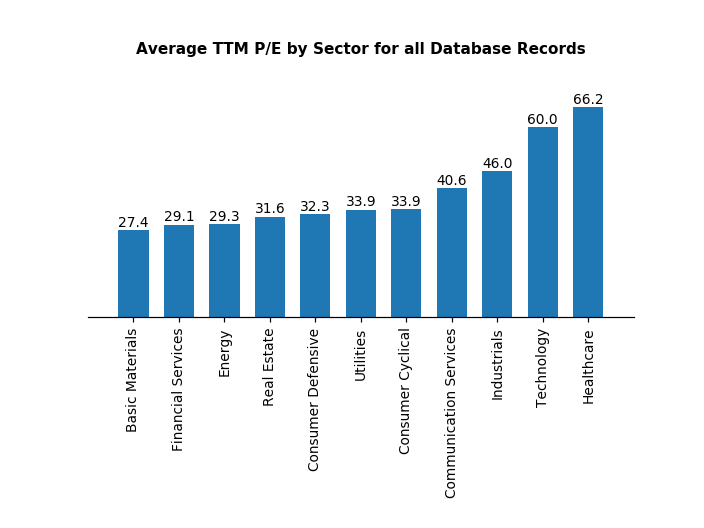

In [284]:
fig_pe, ax_pe = plt.subplots(1)
x = [x*3 for x in range(len(pe['TTM']))]
y = pe['TTM'].sort_values(ascending=True)
bars = ax_pe.bar(x, y, width=2)
plt.xticks(ticks=x, labels=y.index.tolist(), fontsize=9)
for tick in ax_pe.xaxis.get_ticklabels():
    tick.set_rotation(90)
plt.subplots_adjust(bottom=0.4)
plt.title('Average TTM P/E by Sector for all Database Records', fontsize=10, fontweight='bold')
plt.yticks([])
for bar in bars:
    ax_pe.text(bar.get_x()+1, bar.get_height()+1, '{:.1f}'.format(bar.get_height()), 
               color='black', ha='center', fontsize=9)
plt.axis([-3, len(x)*3, 0, 80])
ax_pe.get_children()[22].set_color(None)
ax_pe.get_children()[23].set_color(None)
ax_pe.get_children()[25].set_color(None)

*USA*

In [288]:
pe = val_usa_sector_mean.iloc[:, 0:11]
pe.columns = val_yr_cols
pe['TTM']

sector
Basic Materials           23.903800
Communication Services    38.718408
Consumer Cyclical         34.866476
Consumer Defensive        32.394366
Energy                    39.252530
Financial Services        28.249057
Healthcare                64.388257
Industrials               53.404394
Real Estate               44.450980
Technology                54.644835
Utilities                 48.827458
Name: TTM, dtype: float64

<IPython.core.display.Javascript object>


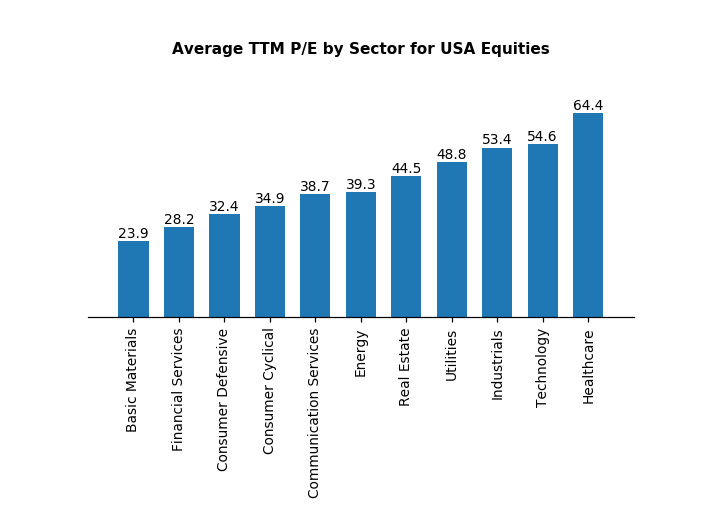

In [291]:
fig_pe, ax_pe = plt.subplots(1)
x = [x*3 for x in range(len(pe['TTM']))]
y = pe['TTM'].sort_values(ascending=True)
bars = ax_pe.bar(x, y, width=2)
plt.xticks(ticks=x, labels=y.index.tolist(), fontsize=9)
for tick in ax_pe.xaxis.get_ticklabels():
    tick.set_rotation(90)
plt.subplots_adjust(bottom=0.4)
plt.title('Average TTM P/E by Sector for USA Equities', fontsize=10, fontweight='bold')
plt.yticks([])
for bar in bars:
    ax_pe.text(bar.get_x()+1, bar.get_height()+1, '{:.1f}'.format(bar.get_height()), 
               color='black', ha='center', fontsize=9)
plt.axis([-3, len(x)*3, 0, 80])
ax_pe.get_children()[22].set_color(None)
ax_pe.get_children()[23].set_color(None)
ax_pe.get_children()[25].set_color(None)

In [292]:
val_indus_mean = df_val.groupby(by=['sector', 'industry']).mean()
val_indus_mean

PE_Y0  \
sector                 industry                                              
Basic Materials        Agricultural Inputs                       68.052212   
                       Aluminum                                  75.782759   
                       Building Materials                        88.626667   
                       Chemicals                                102.706667   
                       Coal                                      33.486555   
                       Copper                                    32.019565   
                       Gold                                      45.518142   
                       Industrial Metals & Minerals              51.678821   
                       Lumber & Wood Production                  31.855263   
                       Paper & Paper Products                    39.872816   
                       Silver                                    67.695652   
                       Specialty Chemicals                       49.225161   
                       Steel                                     49.865174   
Communication Services Pay TV                                    14.365000   
                       Telecom Services                          27.713423   
Consumer Cyclical      Advertising Agencies                      23.623077   
                       Apparel Manufacturing                     34.427397   
                       Apparel Stores                            35.582031   
                       Auto & Truck Dealerships                  43.997674   
                       Auto Manufacturers                        44.876429   
                       Auto Parts                                59.888889   
                       Broadcasting - Radio                      23.023077   
                       Broadcasting - TV                         27.959140   
                       Department Stores                         53.728571   
                       Footwear & Accessories                    18.405208   
                       Gambling                                  28.015493   
                       Home Furnishings & Fixtures               32.908411   
                       Home Improvement Stores                   27.371429   
                       Leisure                                   49.852761   
                       Lodging                                  146.970707   
...                                                                    ...   
Real Estate            REIT - Industrial                         30.752381   
                       REIT - Office                             45.614894   
                       REIT - Residential                       197.472222   
                       REIT - Retail                             97.590909   
                       Real Estate - General                     53.461765   
                       Real Estate Services                      77.987037   
Technology             Communication Equipment                   46.115414   
                       Computer Distribution                     15.585714   
                       Computer Systems                          63.332143   
                       Consumer Electronics                      58.266860   
                       Contract Manufacturers                    23.028000   
                       Data Storage                              37.840000   
                       Electronic Components                    125.780000   
                       Electronic Gaming & Multimedia            40.713559   
                       Electronics Distribution                  25.279487   
                       Health Information Services              100.861224   
                       Information Technology Services           22.892982   
                       Internet Content & Information            37.307031   
                       Scientific & Technical Instruments        62.376056   
             

In [87]:
list(enumerate(df_val.head().columns.values.tolist()))

[(0, 'country'),
 (1, 'country_name'),
 (2, 'exchange_symbol'),
 (3, 'exchange'),
 (4, 'ticker'),
 (5, 'company'),
 (6, 'type_code'),
 (7, 'type'),
 (8, 'sector'),
 (9, 'industry'),
 (10, 'fy_end'),
 (11, 'updated'),
 (12, 'Y0'),
 (13, 'Y1'),
 (14, 'Y2'),
 (15, 'Y3'),
 (16, 'Y4'),
 (17, 'Y5'),
 (18, 'Y6'),
 (19, 'Y7'),
 (20, 'Y8'),
 (21, 'Y9'),
 (22, 'Y10'),
 (23, 'PE_Y0'),
 (24, 'PE_Y1'),
 (25, 'PE_Y2'),
 (26, 'PE_Y3'),
 (27, 'PE_Y4'),
 (28, 'PE_Y5'),
 (29, 'PE_Y6'),
 (30, 'PE_Y7'),
 (31, 'PE_Y8'),
 (32, 'PE_Y9'),
 (33, 'PE_Y10'),
 (34, 'PS_Y0'),
 (35, 'PS_Y1'),
 (36, 'PS_Y2'),
 (37, 'PS_Y3'),
 (38, 'PS_Y4'),
 (39, 'PS_Y5'),
 (40, 'PS_Y6'),
 (41, 'PS_Y7'),
 (42, 'PS_Y8'),
 (43, 'PS_Y9'),
 (44, 'PS_Y10'),
 (45, 'PB_Y0'),
 (46, 'PB_Y1'),
 (47, 'PB_Y2'),
 (48, 'PB_Y3'),
 (49, 'PB_Y4'),
 (50, 'PB_Y5'),
 (51, 'PB_Y6'),
 (52, 'PB_Y7'),
 (53, 'PB_Y8'),
 (54, 'PB_Y9'),
 (55, 'PB_Y10'),
 (56, 'PC_Y0'),
 (57, 'PC_Y1'),
 (58, 'PC_Y2'),
 (59, 'PC_Y3'),
 (60, 'PC_Y4'),
 (61, 'PC_Y5'),
 (62, 'PC_Y6

In [16]:
df = None # Set df variable to none to close db connection 

Database connection for file db/mstables2.sqlite closed.
